# Galaxies vs Quasars
### Time to get your hands dirty. Galaxy vs quasars

We're now going to classify galaxy vs quasars in the Sloan Digital Sky Survey. 

This is one of the most famous example of machine-learning classification in astronomy. For some recent work see e.g. 
- *Identifying galaxies, quasars, and stars with machine learning: A new catalogue of classifications for 111 million SDSS sources without spectra* Clarke et al (2019) [arXiv:1909.10963](https://arxiv.org/abs/1909.10963)
- *Quasar and galaxy classification in Gaia Data Release 2* Bailer-Jones et al (2019) [arXiv:1910.05255](https://arxiv.org/abs/1910.05255)

Some figures from the second paper:

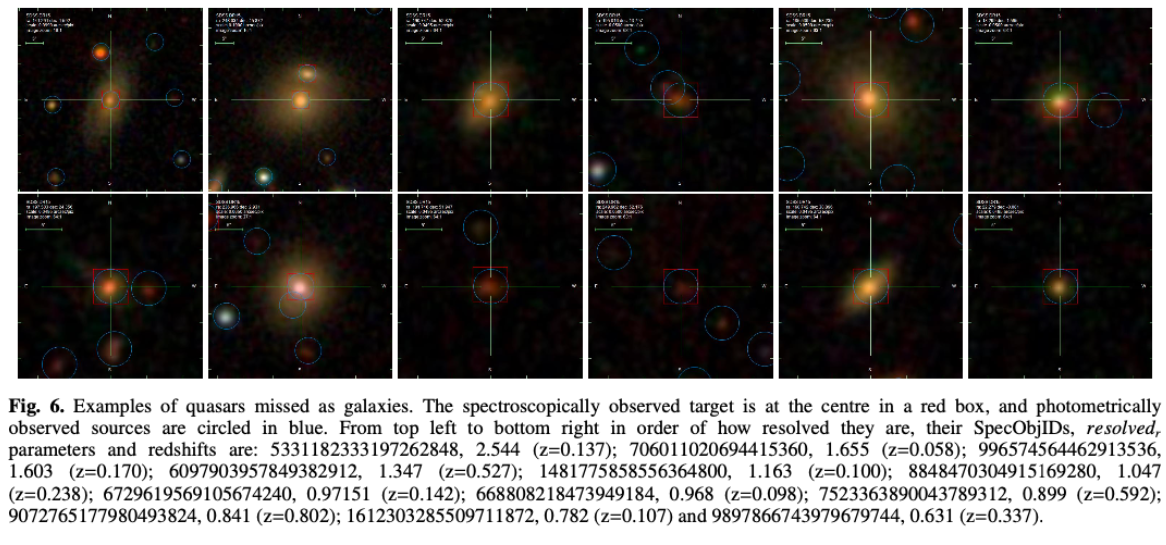

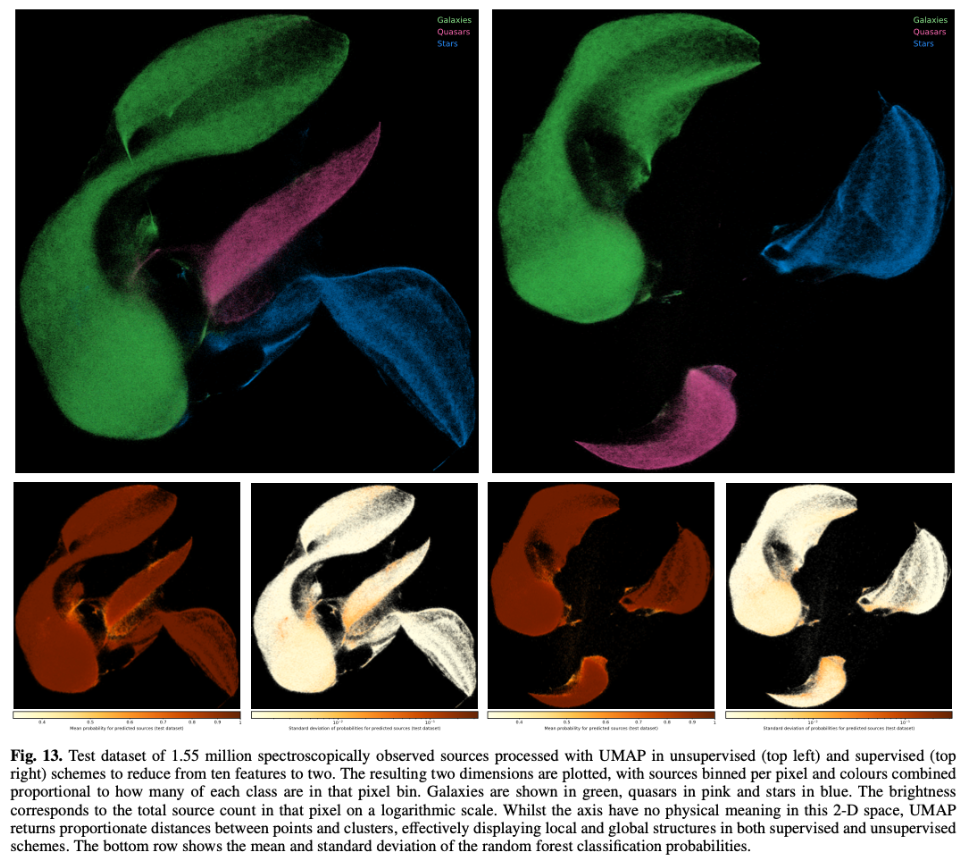

In [1]:
from IPython.display import Image, display
display(Image(filename='../../Images/Gal vs Quasars I.png'))
display(Image(filename='../../Images/Gal vs Quasars II.png'))

![Screen%20Shot%202022-02-08%20at%2014.16.28.png](attachment:Screen%20Shot%202022-02-08%20at%2014.16.28.png)

SDSS observed in four bands:
    
![](https://speclite.readthedocs.io/en/latest/_images/sdss2010.png) 
    

#### Data

The dataset is at `solutions/galaxyquasar.csv`. I have extracted it myself from the SDSS database using the SQL query reported [here](https://www.astroml.org/_modules/astroML/datasets/sdss_galaxy_colors.html#fetch_sdss_galaxy_colors)

(If you've never used [SQL](https://en.wikipedia.org/wiki/SQL) and want to learn something new it's computing, it's very powerful)

#### Tasks

- Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 
- Classify the dataset against the target label.
- Try some of the classification methods we've seen so far and evaluate the performance using the ROC curve.
- Remember to split the dataset into training and validation...

#### Ideas
- Try using different colors (a subset of them first, than all together). Which is the most important feature?
- What are the colors that better satisfy or invalidate the "Naive" assumption of independence between the attributes?


In [163]:
import emcee
import corner
import numpy as np
from scipy import stats
from astropy.table import Table
import pandas as pd

from astroML.utils import completeness_contamination
from astroML.utils.decorators import pickle_results
from astroML.utils import split_samples
from astroML.classification import GMMBayes
from astroML.resample import bootstrap

import sklearn
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import RocCurveDisplay

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Fetching and visualizing the data

In [164]:
data = pd.read_csv('../solutions/galaxyquasar.csv')

data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [165]:
u_g = np.array(data['u']-data['g'])
g_r = np.array(data['g']-data['r'])
r_i = np.array(data['r']-data['i'])
i_z = np.array(data['i']-data['z'])

labels = data['class']

In [166]:
ND_dataset = np.array([u_g, g_r, r_i, i_z]).T
labels_01  = np.where(labels=='QSO', 1, 0)    # 1=QSO, 0=GALAXY
legends    = ['u-g', 'g-r', 'r-i', 'i-z']

### Corner Plot

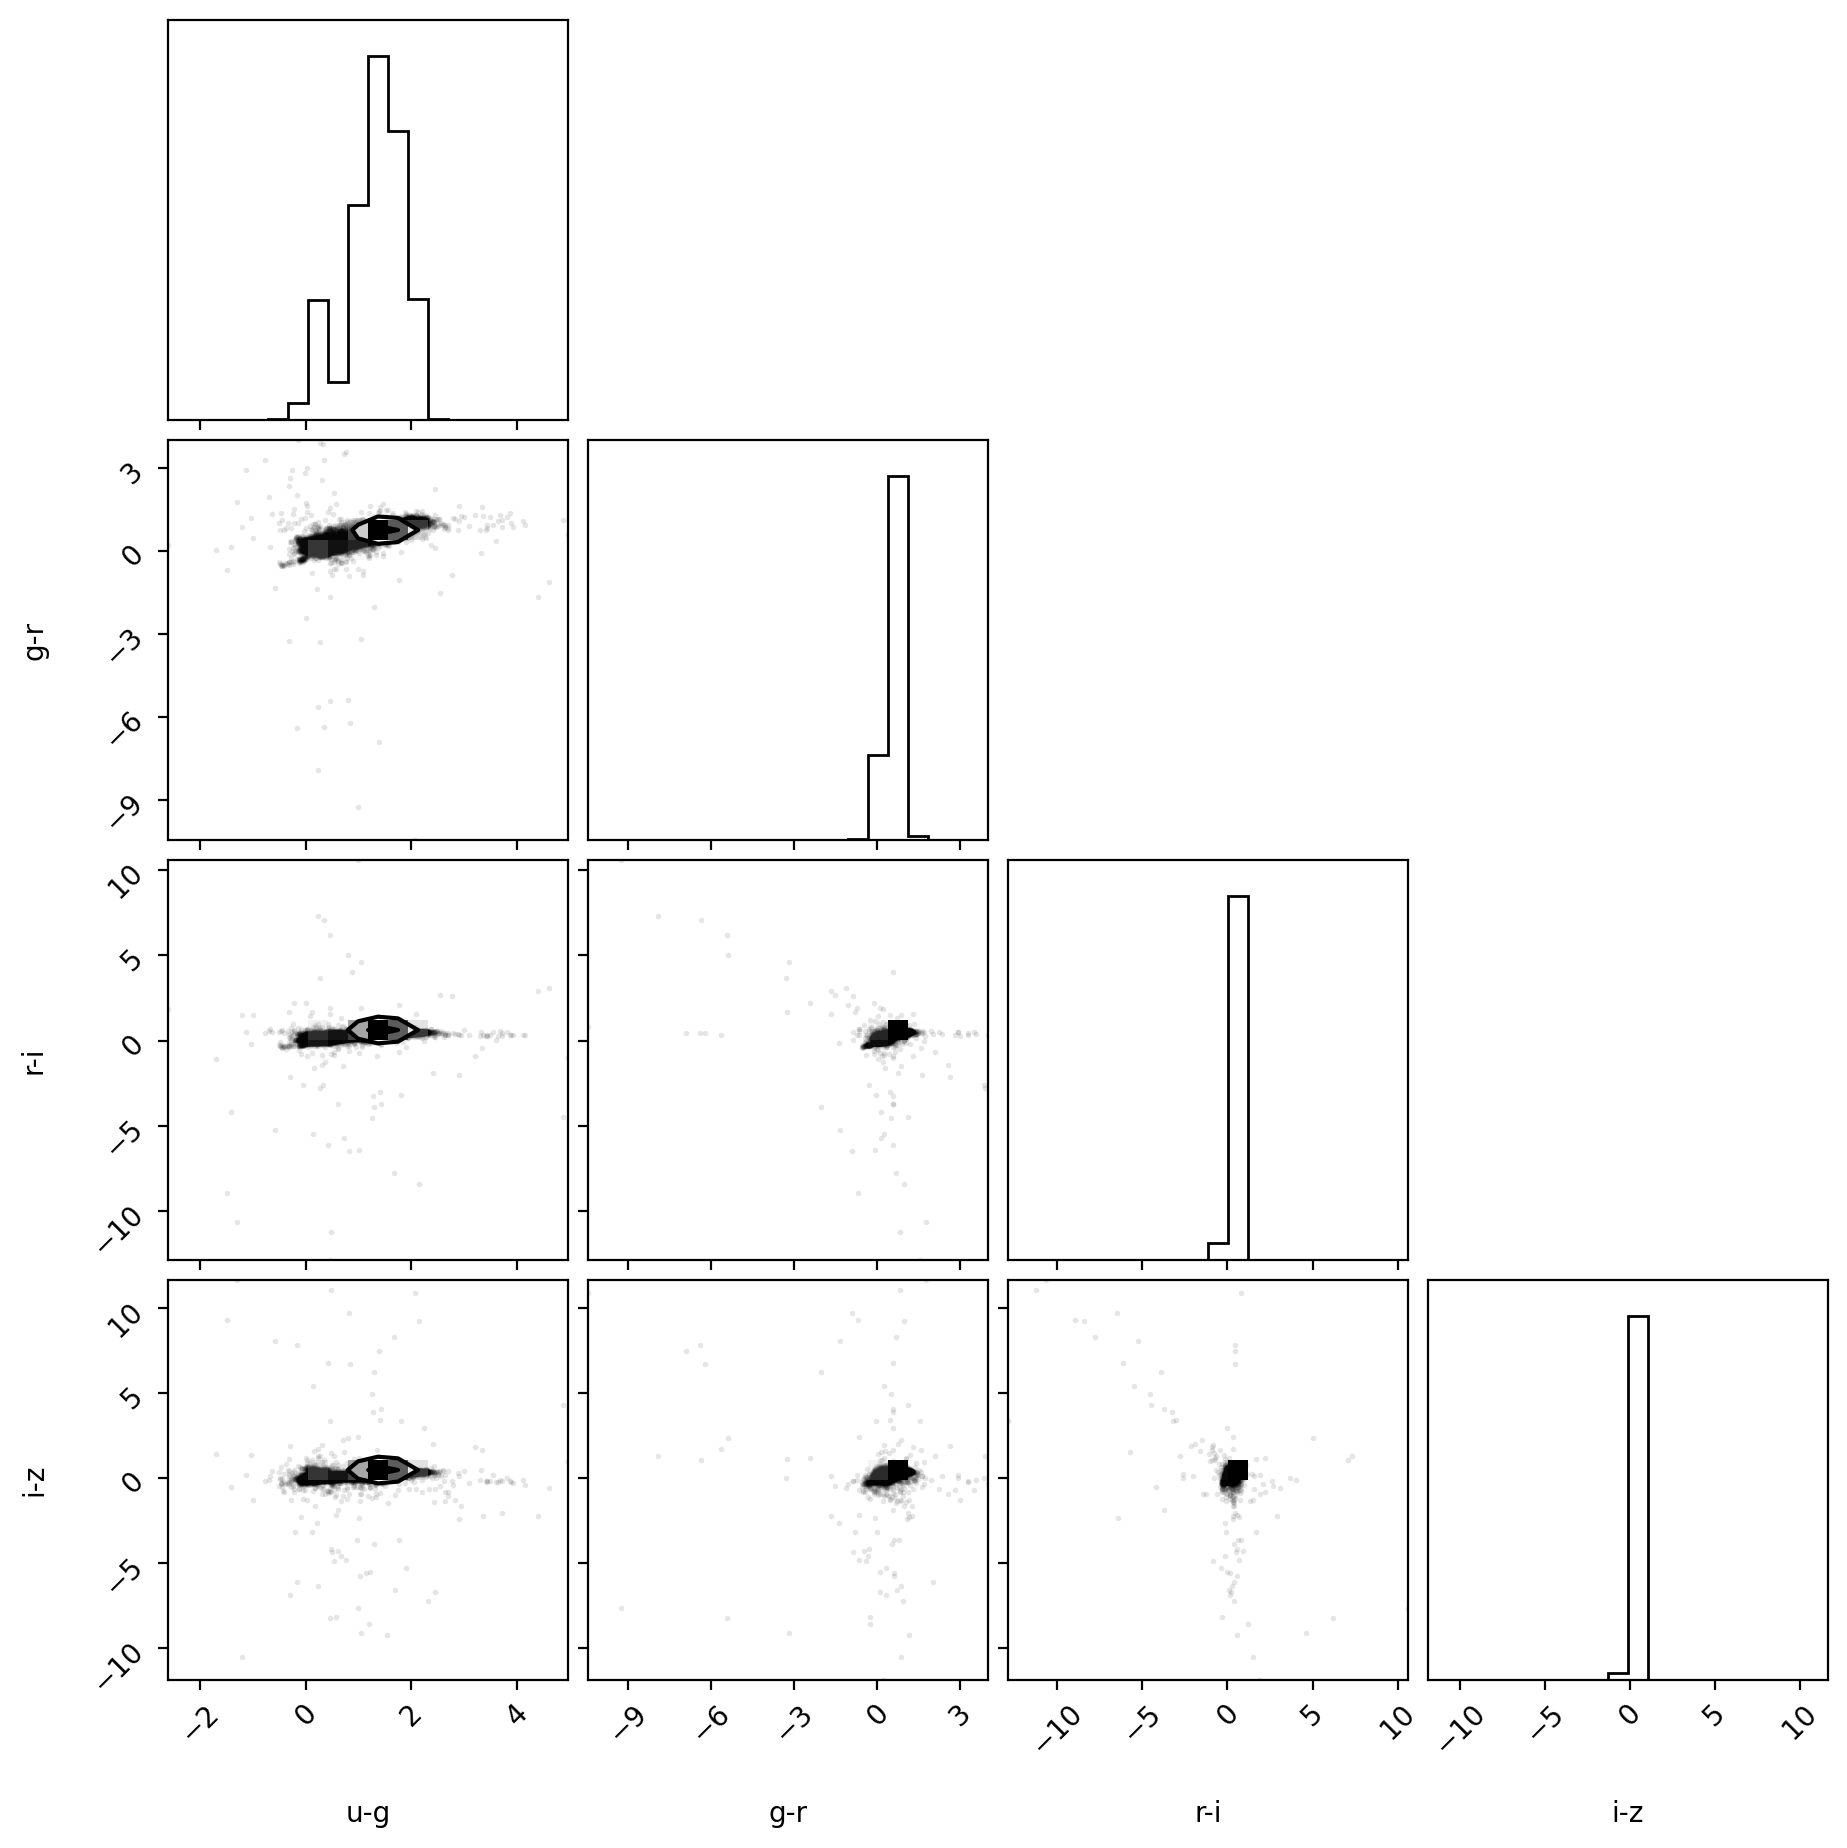

In [167]:
import corner
corner.corner(np.array([u_g, g_r, r_i, i_z]).T, labels=legends);

### Color Distribution

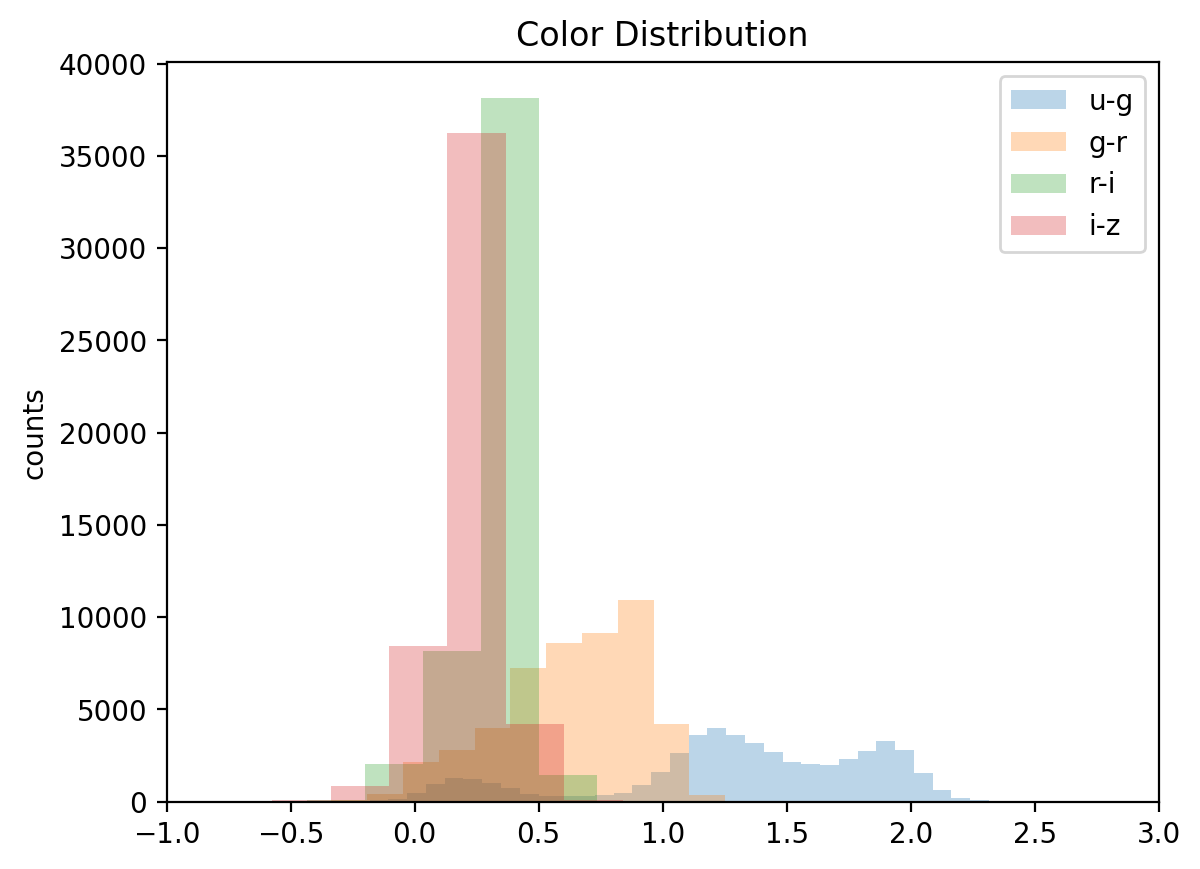

In [168]:
plt.hist(u_g, bins=100, alpha=0.3, label='u-g')
plt.hist(g_r, bins=100, alpha=0.3, label='g-r')
plt.hist(r_i, bins=100, alpha=0.3, label='r-i')
plt.hist(i_z, bins=100, alpha=0.3, label='i-z')
plt.ylabel('counts')
plt.xlim(-1.0, 3.0)
plt.title('Color Distribution')
plt.legend();

### Galaxies or Quasars?

In [169]:
galaxies_idx = np.array(np.where(data['class']=='GALAXY'))
quasars_idx  = np.array(np.where(data['class']=='QSO'))

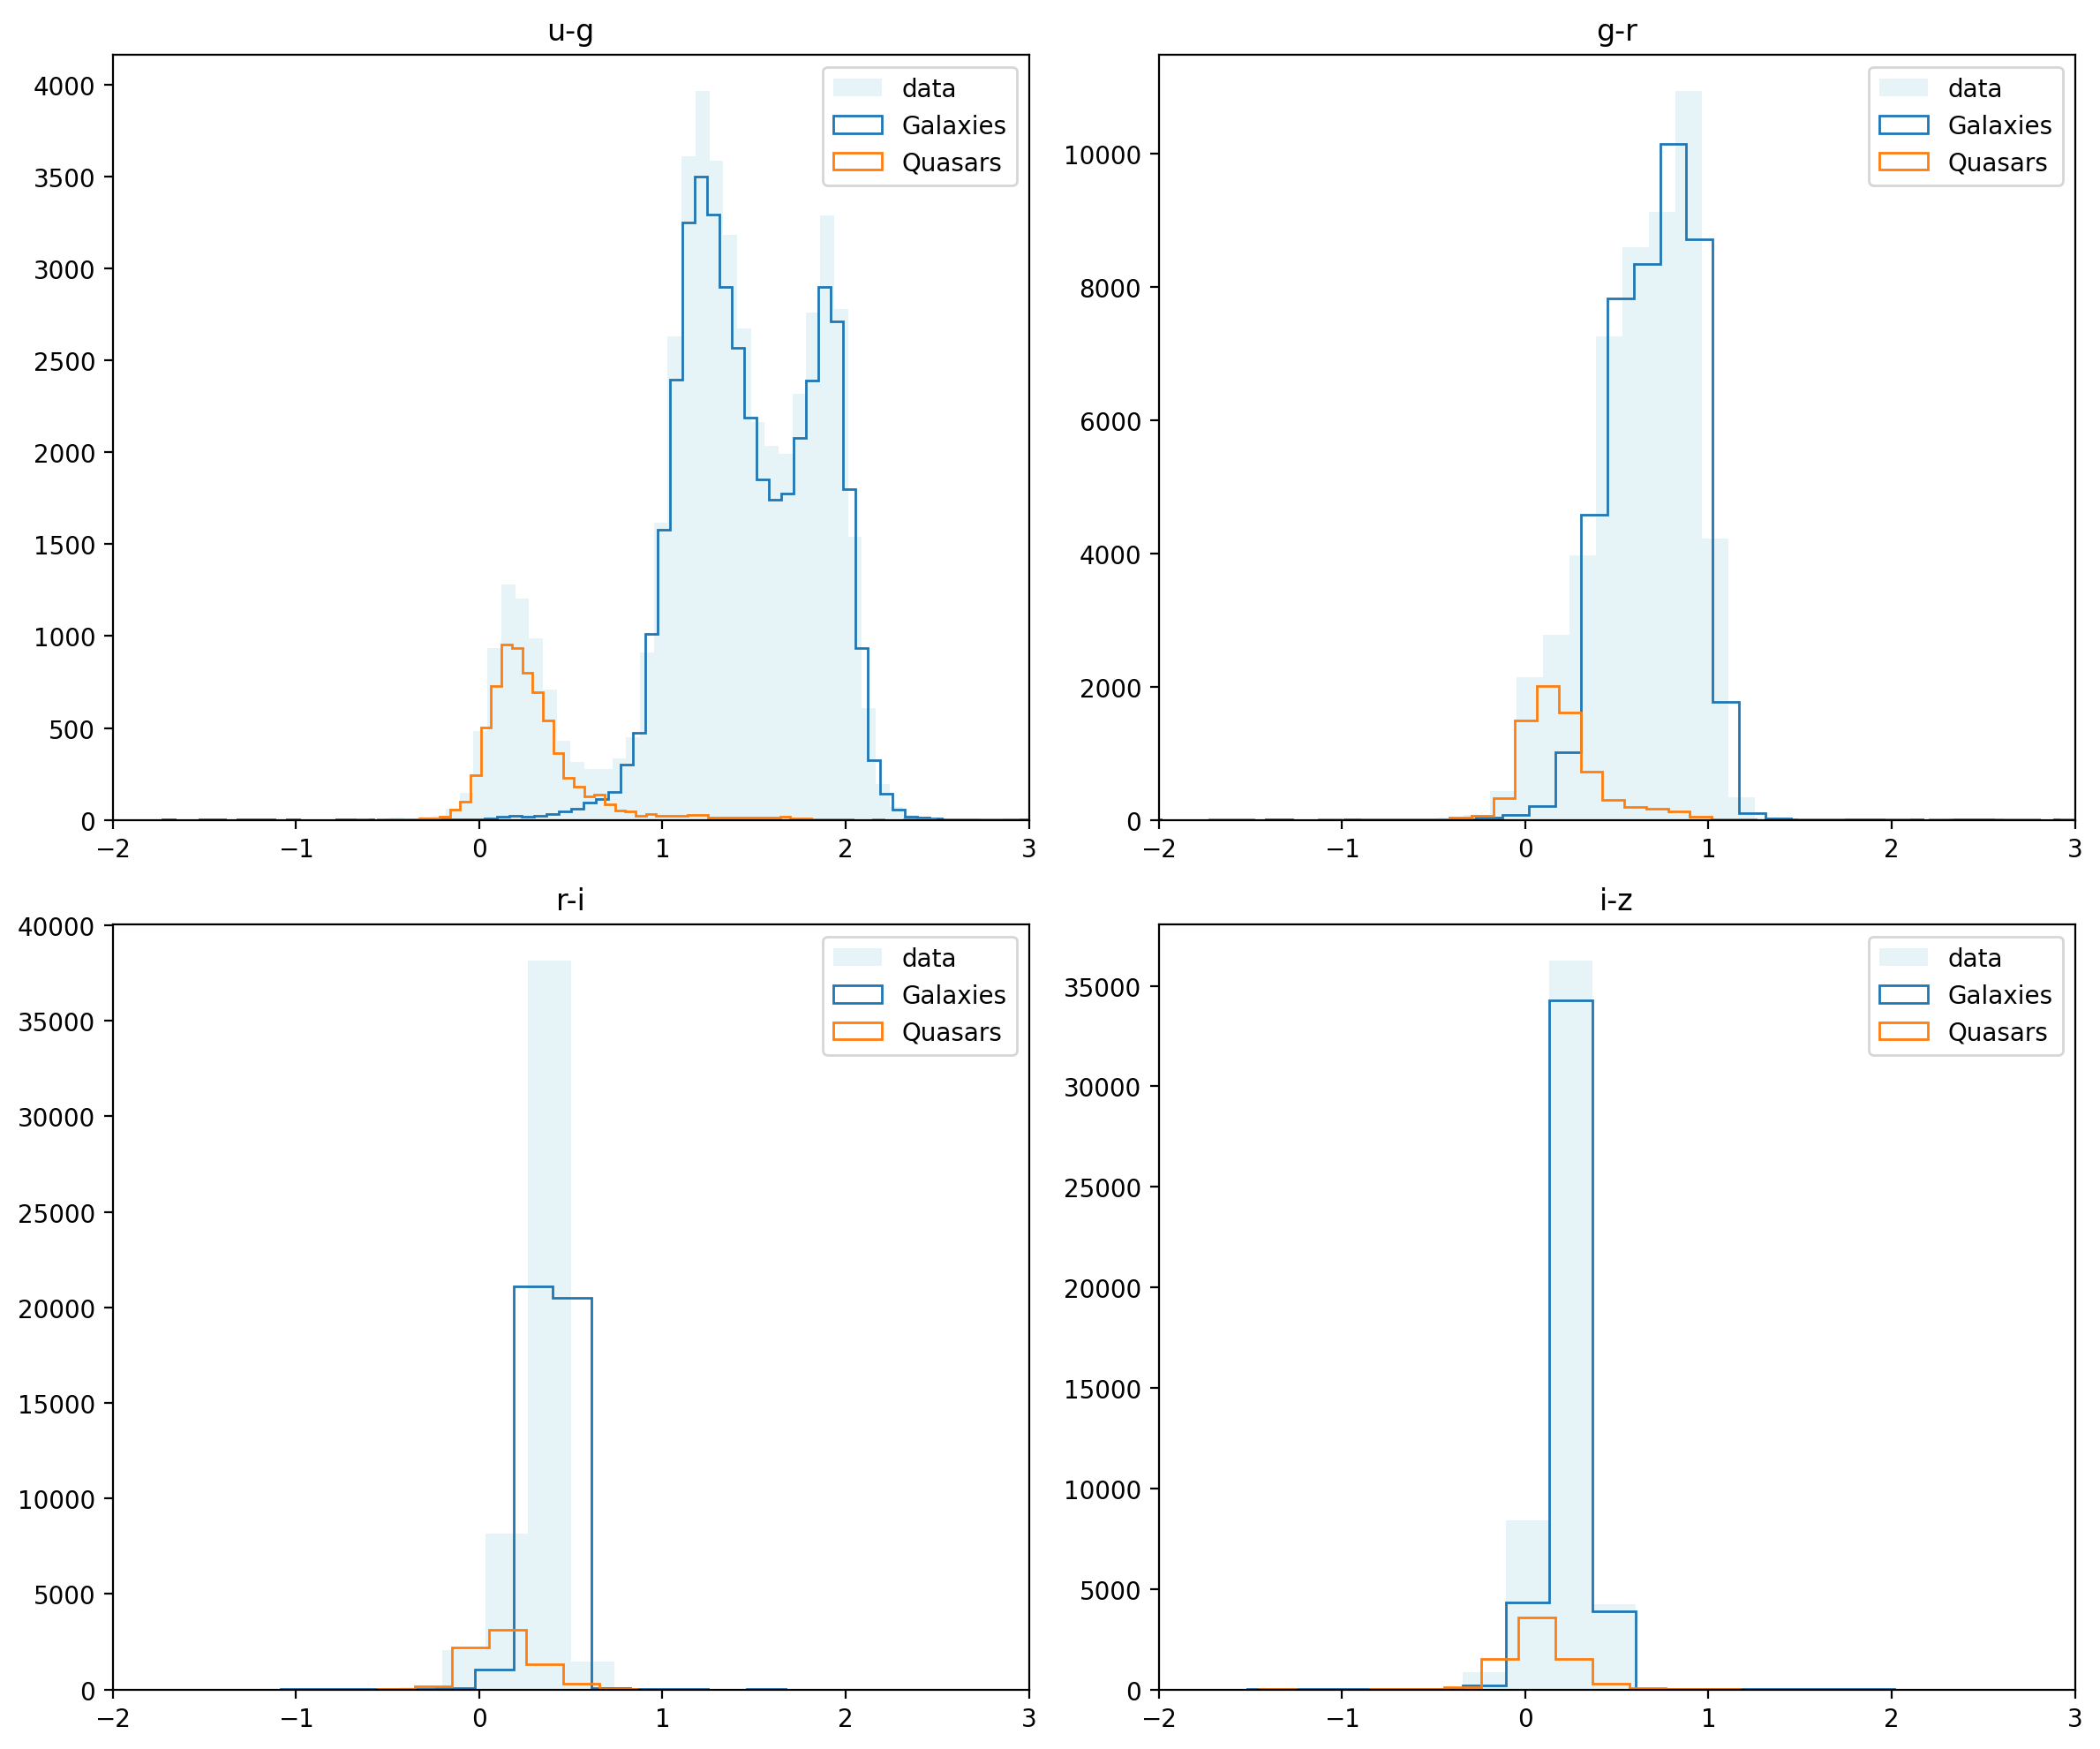

In [170]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))

for i, ax, xlabel in zip(np.arange(0,4), axes.flatten(), legends):
    dataset = ND_dataset[:,i]
    ax.hist(dataset, bins=100, label='data', color='lightblue', alpha=0.3)
    ax.hist(dataset[labels_01==0], bins=100, histtype='step', label='Galaxies')
    ax.hist(dataset[labels_01==1], bins=100, histtype='step', label='Quasars')
    ax.legend()
    ax.set_xlim(-2, 3)
    ax.set_title(xlabel)

plt.tight_layout();


We can clearly see a **bimodality** in the $u-g$ color!

## Classification

### Split the dataset into a train and a test set

In [171]:
# Subset (u-g)
X_train, X_test, y_train, y_validation = train_test_split(u_g, labels_01, test_size=0.33, random_state=1)

# all data
X_train_all, X_test_all, y_train_all, y_test_all =  train_test_split(ND_dataset, labels_01, test_size=0.33, random_state=1)

### Naive Bayes
#### u-g

In [172]:
gnb = GaussianNB()
gnb.fit(X_train[:,None], y_train)

y_pred_GNB = gnb.predict(X_test[:,None])

In [173]:
completenessGNB, contaminationGNB = completeness_contamination(y_pred_GNB, y_test)

print(f'Completeness:   {completenessGNB:.3f}')
print(f'Contamination:  {contaminationGNB:.3f}')

Completeness:   0.937
Contamination:  0.067


##### Roc Curve

In [174]:
y_score_GNB = [gnb.predict_proba(X_test[:,None])[:,0], gnb.predict_proba(X_test[:,None])[:,1]]

Text(0.5, 1.0, 'ROC Curve')

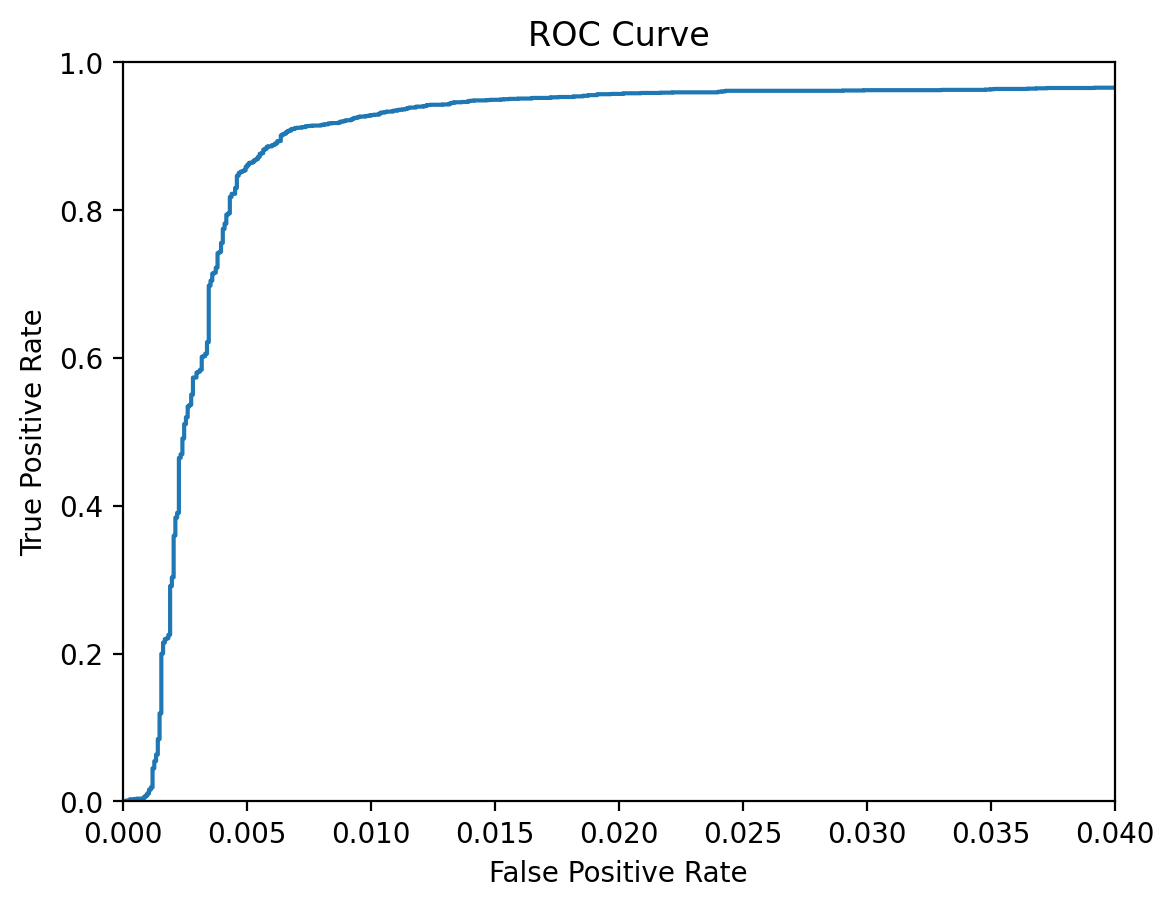

In [186]:
fpr, tpr, _ = roc_curve(y_test, y_score_GNB[1], pos_label=None, sample_weight=None, drop_intermediate=True)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlim(0, 0.04)
plt.ylim(0,1)
plt.title('ROC Curve')

#### Complete Dataset

In [177]:
gnb_all = GaussianNB()
gnb_all.fit(X_train_all, y_train_all)
y_pred_GNB_all = gnb_all.predict(X_test_all)

In [179]:
completenessGNB_all, contaminationGNB_all = completeness_contamination(y_pred_GNB_all, y_test_all)

print(f'Completeness:   {completenessGNB_all:.3f}')
print(f'Contamination:  {contaminationGNB_all:.3f}')

Completeness:   0.930
Contamination:  0.109


##### Roc Curve

In [183]:
y_score_GNB_all = [gnb_all.predict_proba(X_test_all)[:,0], gnb_all.predict_proba(X_test_all)[:,1]]

Text(0.5, 1.0, 'ROC Curve')

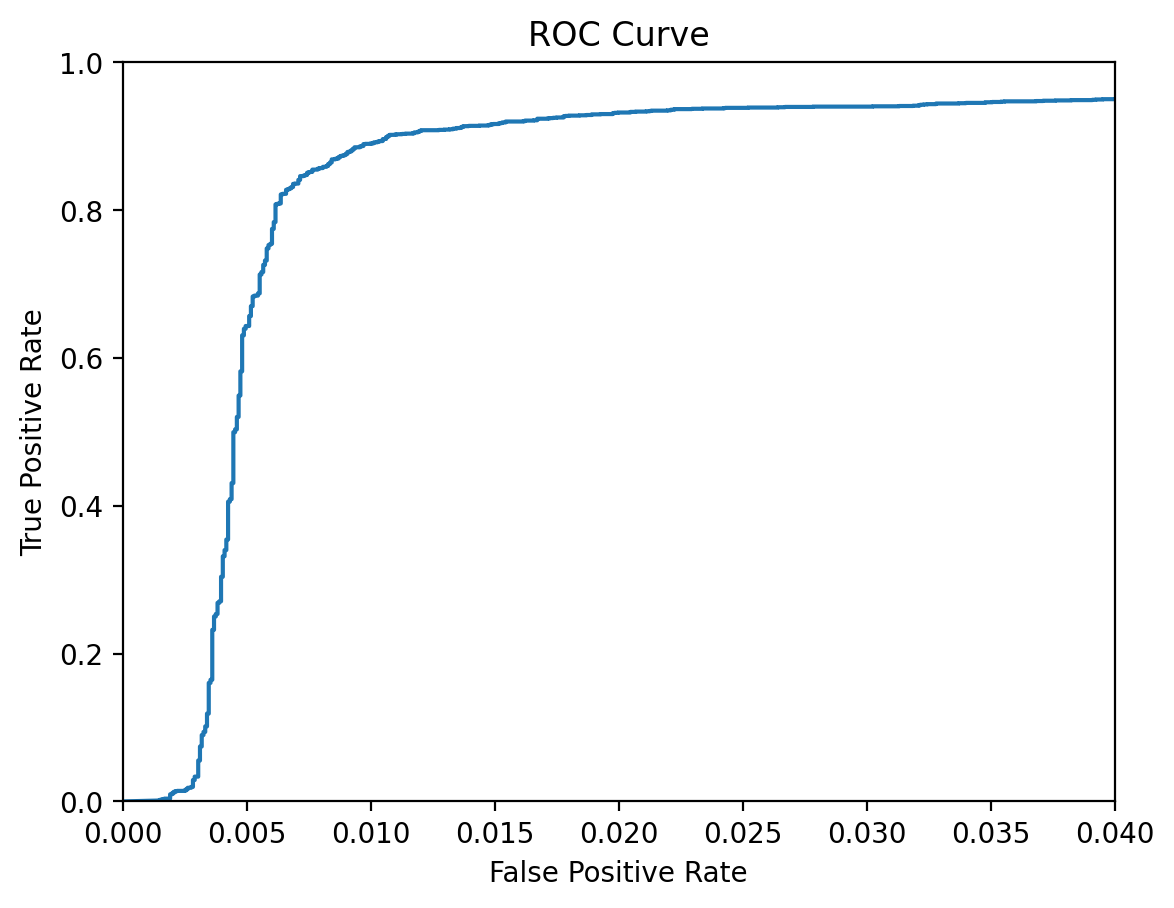

In [185]:
fpr, tpr, _ = roc_curve(y_test_all, y_score_GNB_all[1], pos_label=None, sample_weight=None, drop_intermediate=True)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlim(0, 0.04)
plt.ylim(0,1)
plt.title('ROC Curve')

### Linear Discriminant Analysis (LDA)

#### u-g

In [187]:
lda = LDA()
lda.fit(X_train[:,None], y_train)
y_pred_LDA = lda.predict(X_test[:,None])

In [188]:
completenessLDA, contaminationLDA = completeness_contamination(y_pred_LDA, y_test)

print(f'Completeness:   {completenessLDA:.3f}')
print(f'Contamination:  {contaminationLDA:.3f}')

Completeness:   0.938
Contamination:  0.068


##### Roc Curve

In [189]:
y_score_LDA = [lda.predict_proba(X_test[:,None])[:,0], lda.predict_proba(X_test[:,None])[:,1]]

Text(0.5, 1.0, 'ROC Curve')

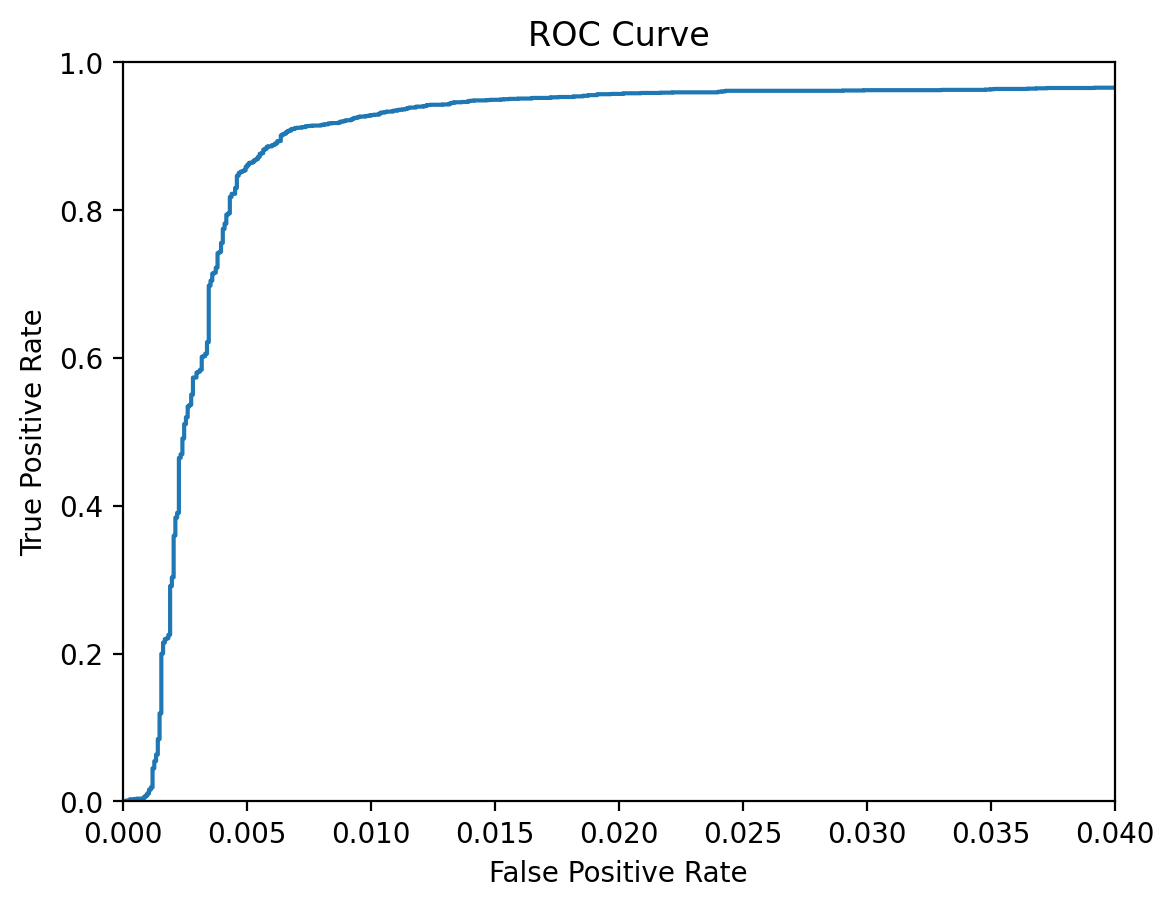

In [190]:
fpr, tpr, _ = roc_curve(y_test, y_score_LDA[1], pos_label=None, sample_weight=None, drop_intermediate=True)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlim(0, 0.04)
plt.ylim(0,1)
plt.title('ROC Curve')

#### Complete Dataset

In [191]:
lda_all = LDA()
lda_all.fit(X_train_all, y_train_all)
y_pred_LDA_all = lda_all.predict(X_test_all)

In [192]:
completenessLDA_all, contaminationLDA_all = completeness_contamination(y_pred_LDA_all, y_test_all)

print(f'Completeness:   {completenessLDA_all:.3f}')
print(f'Contamination:  {contaminationLDA_all:.3f}')

Completeness:   0.936
Contamination:  0.061


##### Roc Curve

In [193]:
y_score_LDA_all = [lda_all.predict_proba(X_test_all)[:,0], lda_all.predict_proba(X_test_all)[:,1]]

Text(0.5, 1.0, 'ROC Curve')

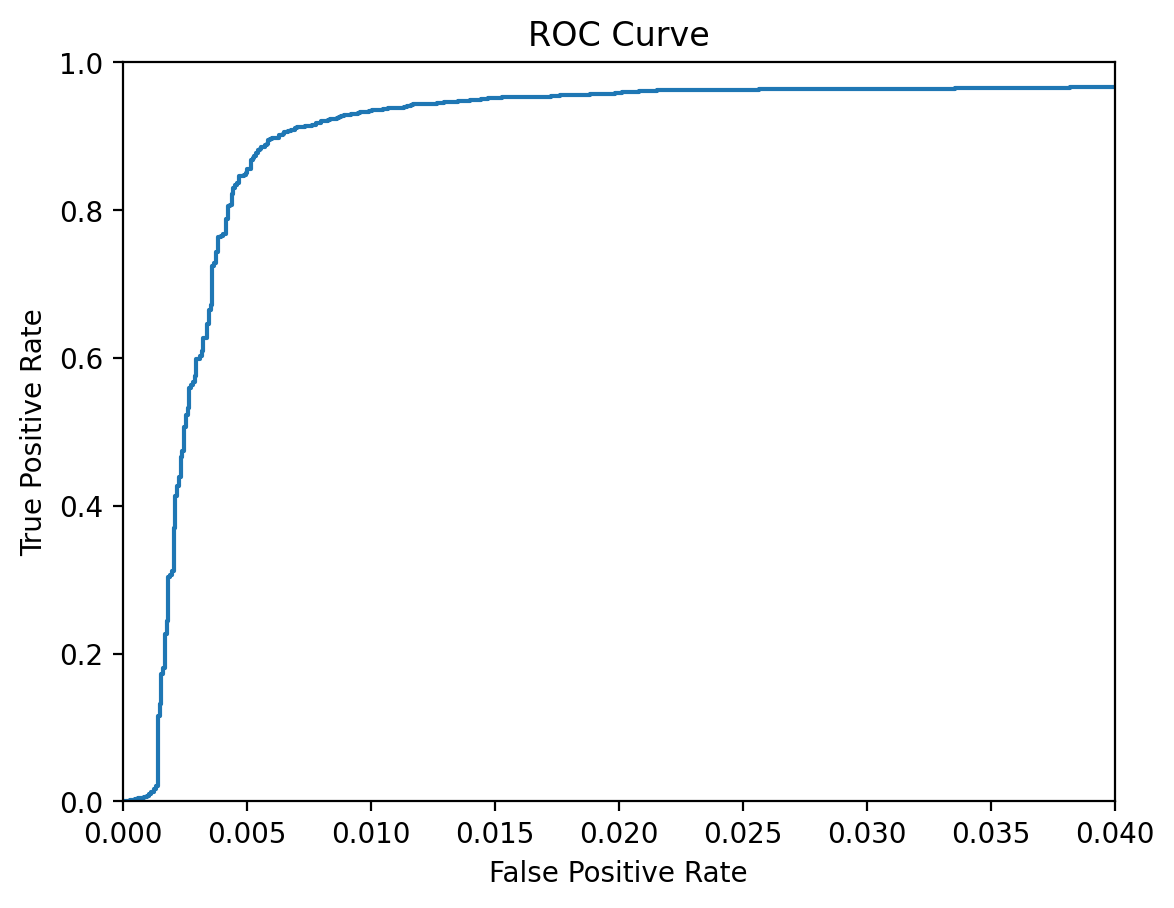

In [194]:
fpr, tpr, _ = roc_curve(y_test_all, y_score_LDA_all[1], pos_label=None, sample_weight=None, drop_intermediate=True)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlim(0, 0.04)
plt.ylim(0,1)
plt.title('ROC Curve')

### Quadratic Discriminant Analysis (QDA)

#### u-g

In [195]:
qda = QDA()
qda.fit(X_train[:,None], y_train)
y_pred_QDA = qda.predict(X_test[:,None])

In [197]:
completenessQDA, contaminationQDA = completeness_contamination(y_pred_QDA, y_test)

print(f'Completeness:   {completenessQDA:.3f}')
print(f'Contamination:  {contaminationQDA:.3f}')

Completeness:   0.937
Contamination:  0.067


##### Roc Curve

In [198]:
y_score_QDA = [qda.predict_proba(X_test[:,None])[:,0], qda.predict_proba(X_test[:,None])[:,1]]

Text(0.5, 1.0, 'ROC Curve')

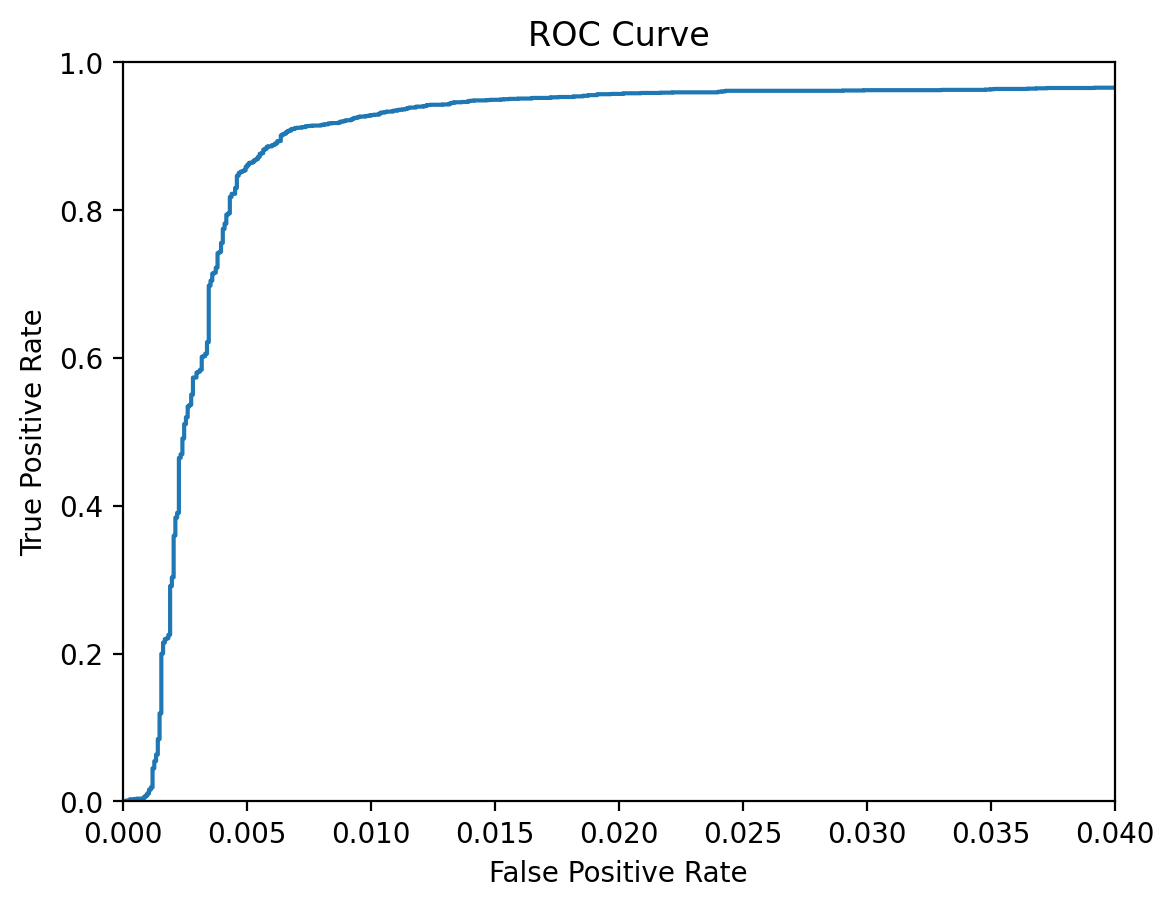

In [199]:
fpr, tpr, _ = roc_curve(y_test, y_score_QDA[1], pos_label=None, sample_weight=None, drop_intermediate=True)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlim(0, 0.04)
plt.ylim(0,1)
plt.title('ROC Curve')

#### Complete Dataset

In [200]:
qda_all = QDA()
qda_all.fit(X_train_all, y_train_all)
y_pred_QDA_all = qda_all.predict(X_test_all)

In [201]:
completenessQDA_all, contaminationQDA_all = completeness_contamination(y_pred_QDA_all, y_test_all)

print(f'Completeness:   {completenessQDA_all:.3f}')
print(f'Contamination:  {contaminationQDA_all:.3f}')

Completeness:   0.923
Contamination:  0.065


##### Roc Curve

In [202]:
y_score_QDA_all = [qda_all.predict_proba(X_test_all)[:,0], qda_all.predict_proba(X_test_all)[:,1]]

Text(0.5, 1.0, 'ROC Curve')

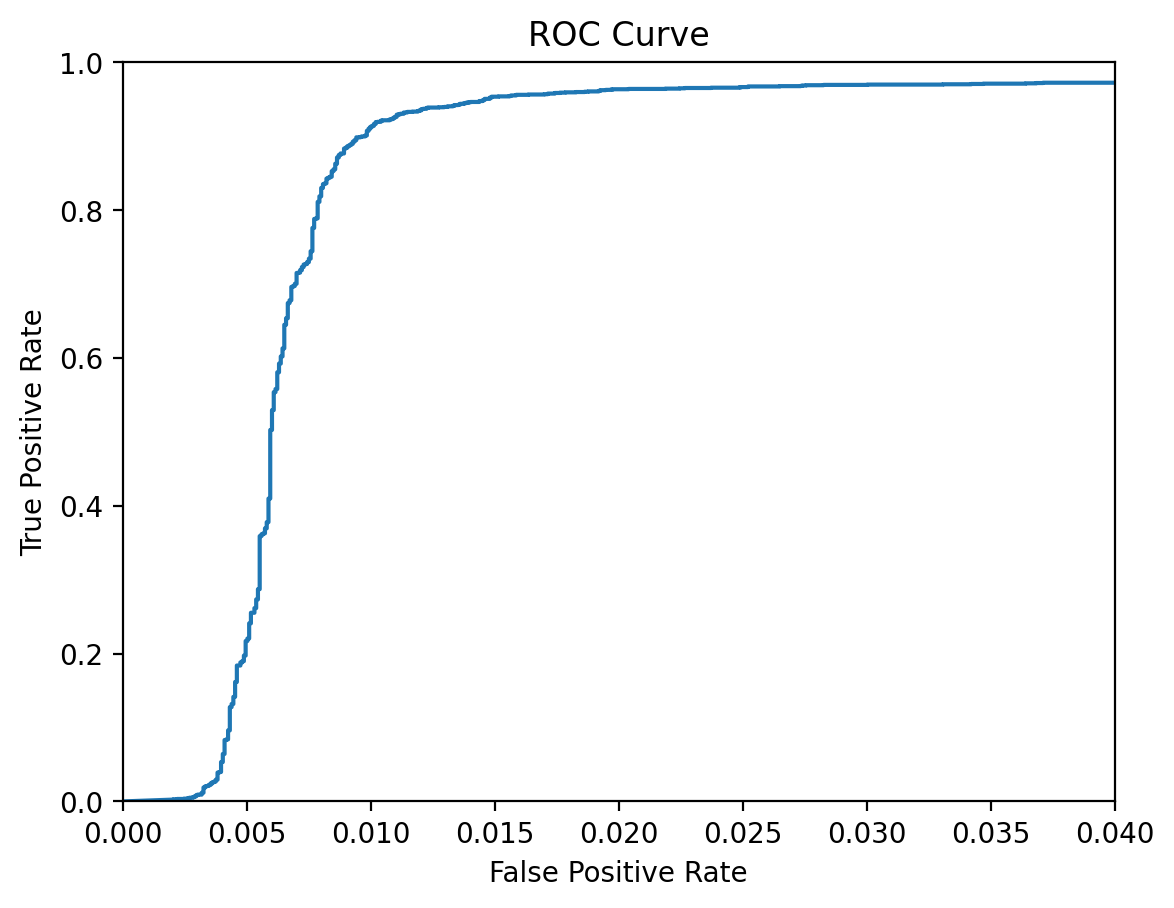

In [203]:
fpr, tpr, _ = roc_curve(y_test_all, y_score_QDA_all[1], pos_label=None, sample_weight=None, drop_intermediate=True)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlim(0, 0.04)
plt.ylim(0,1)
plt.title('ROC Curve')

### Gaussian Mixture Models (GMM)

#### u-g

In [213]:
# How many gaussians? --> CV
classification_acc = []
ks = np.arange(2,30)

for k in ks:
    gmm = GMMBayes(k)
    CV_pred_k = cross_val_predict(gmm, X_test[:,None], y_test)
    classification_acc.append(accuracy_score(y_test, CV_pred_k))

In [226]:
print(f'Max Accuracy for k = {ks[np.argmax(classification_acc)]}')

Max Accuracy for k = 2


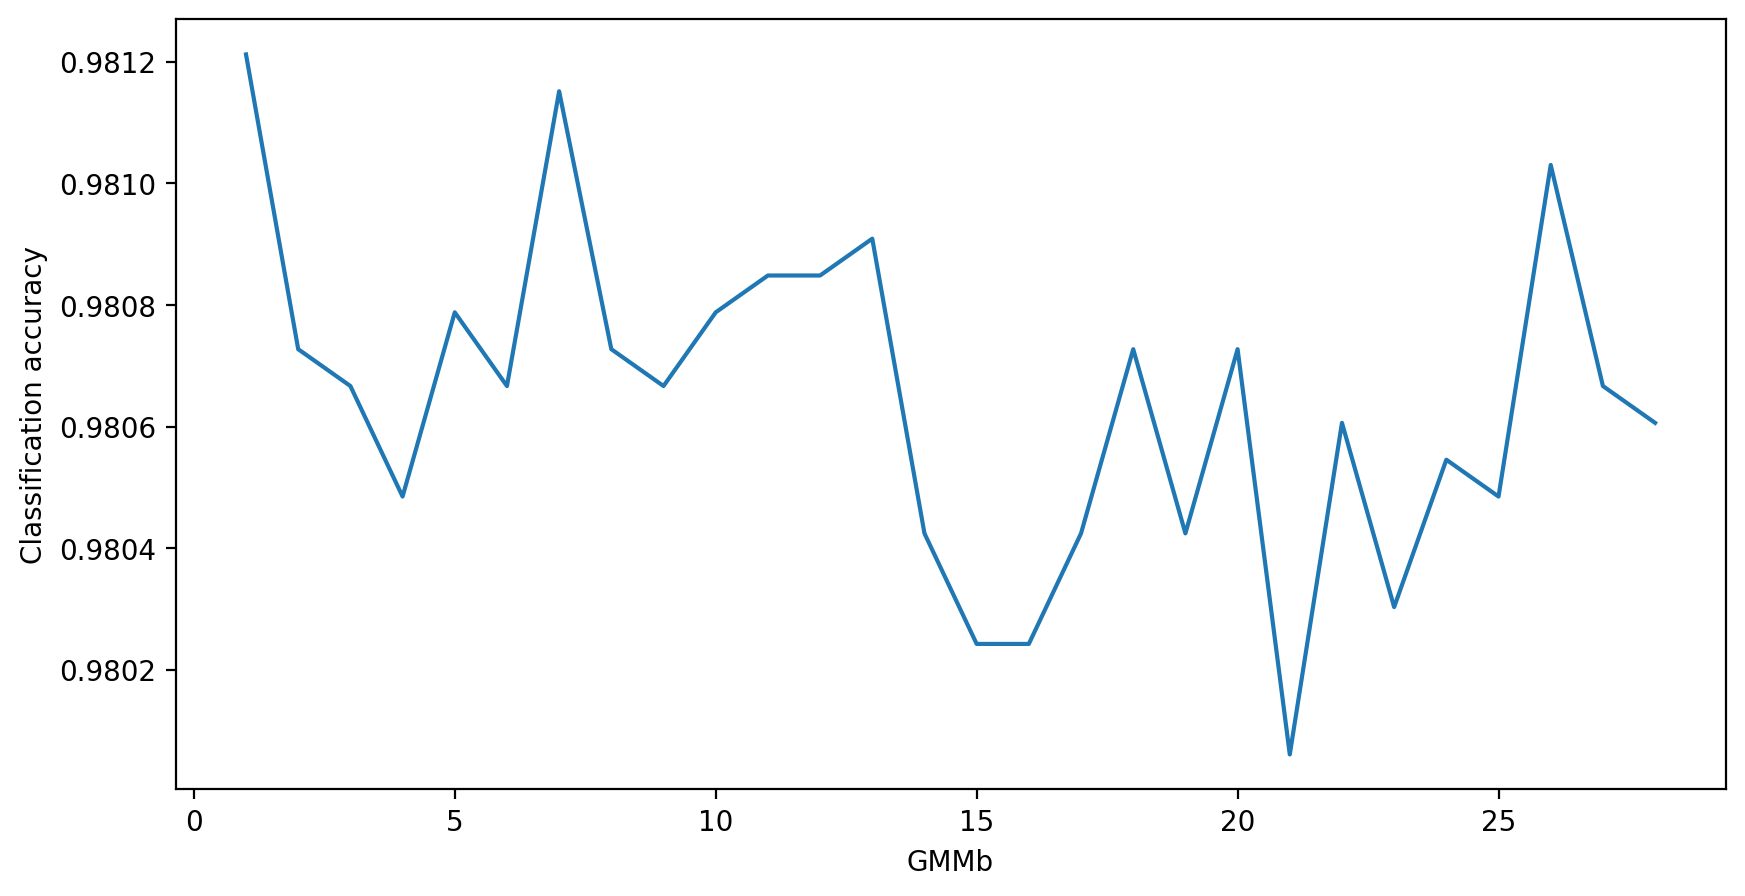

In [227]:
fig = plt.figure(figsize=(10, 5))
u = np.arange(len(classification_acc))+1
plt.plot(u,classification_acc)
plt.xlabel('GMMb')
plt.ylabel('Classification accuracy');

In [228]:
gmmb = GMMBayes(ks[np.argmax(accuracy_score)]) 
gmmb.fit(X_train[:, None], y_train)

y_pred_GMM = gmmb.predict(X_test[:, None])

In [229]:
completenessGMM, contaminationGMM = completeness_contamination(y_pred_GMM, y_test)

print(f'Completeness:  {completenessGMM:.3f}')
print(f'Contamination: {contaminationGMM:.3f}')


Completeness:  0.920
Contamination: 0.054


##### Roc Curve

In [230]:
y_score_GMM = [gmmb.predict_proba(X_test[:,None])[:,0], gmmb.predict_proba(X_test[:,None])[:,1]]

Text(0.5, 1.0, 'ROC Curve')

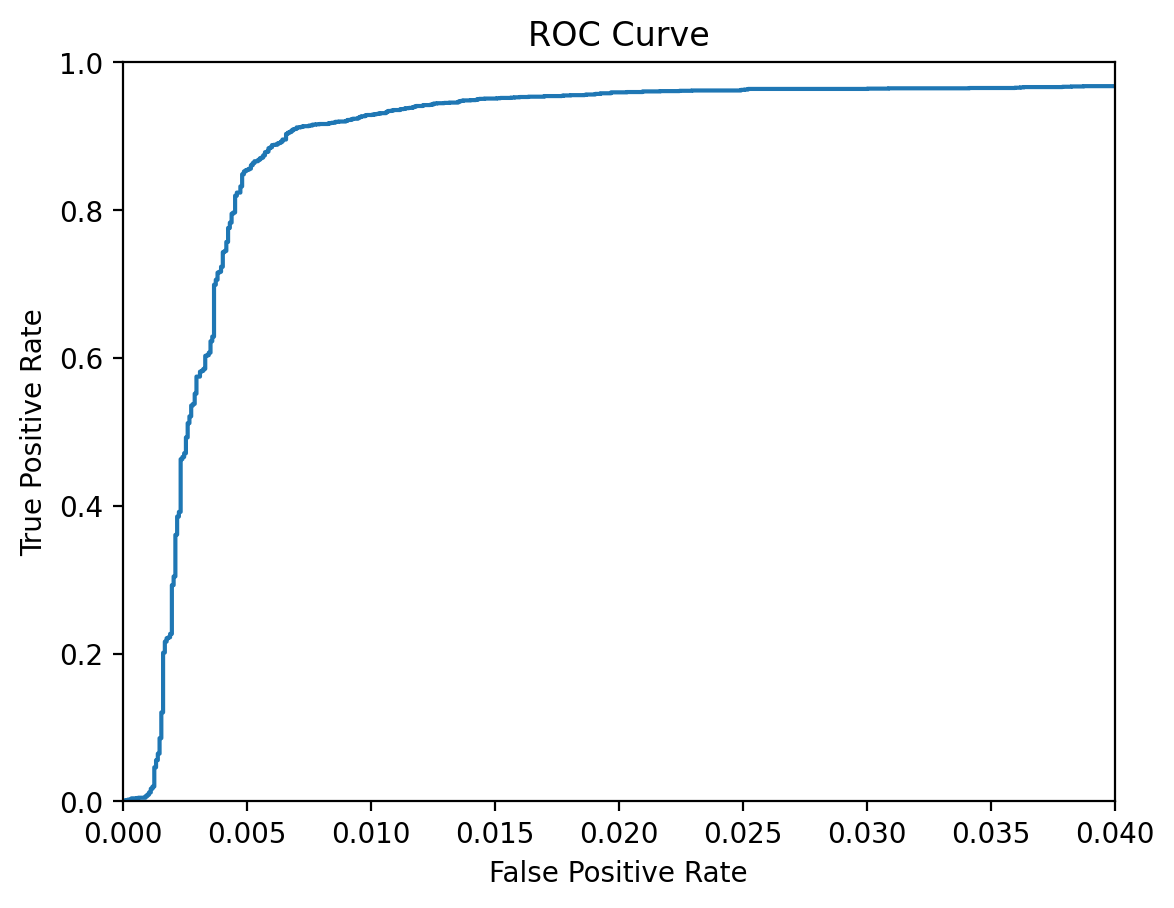

In [231]:
fpr, tpr, _ = roc_curve(y_test, y_score_GMM[1], pos_label=None, sample_weight=None, drop_intermediate=True)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlim(0, 0.04)
plt.ylim(0,1)
plt.title('ROC Curve')

#### Full Dataset

In [225]:
# How many gaussians? --> CV
classification_acc_all = []
ks = np.arange(2,30)

for k in ks:
    gmm = GMMBayes(k)
    CV_pred_k = cross_val_predict(gmm, X_test_all, y_test_all)
    classification_acc_all.append(accuracy_score(y_test_all, CV_pred_k))

In [232]:
print(f'Max Accuracy for k = {ks[np.argmax(classification_acc_all)]}')

Max Accuracy for k = 22


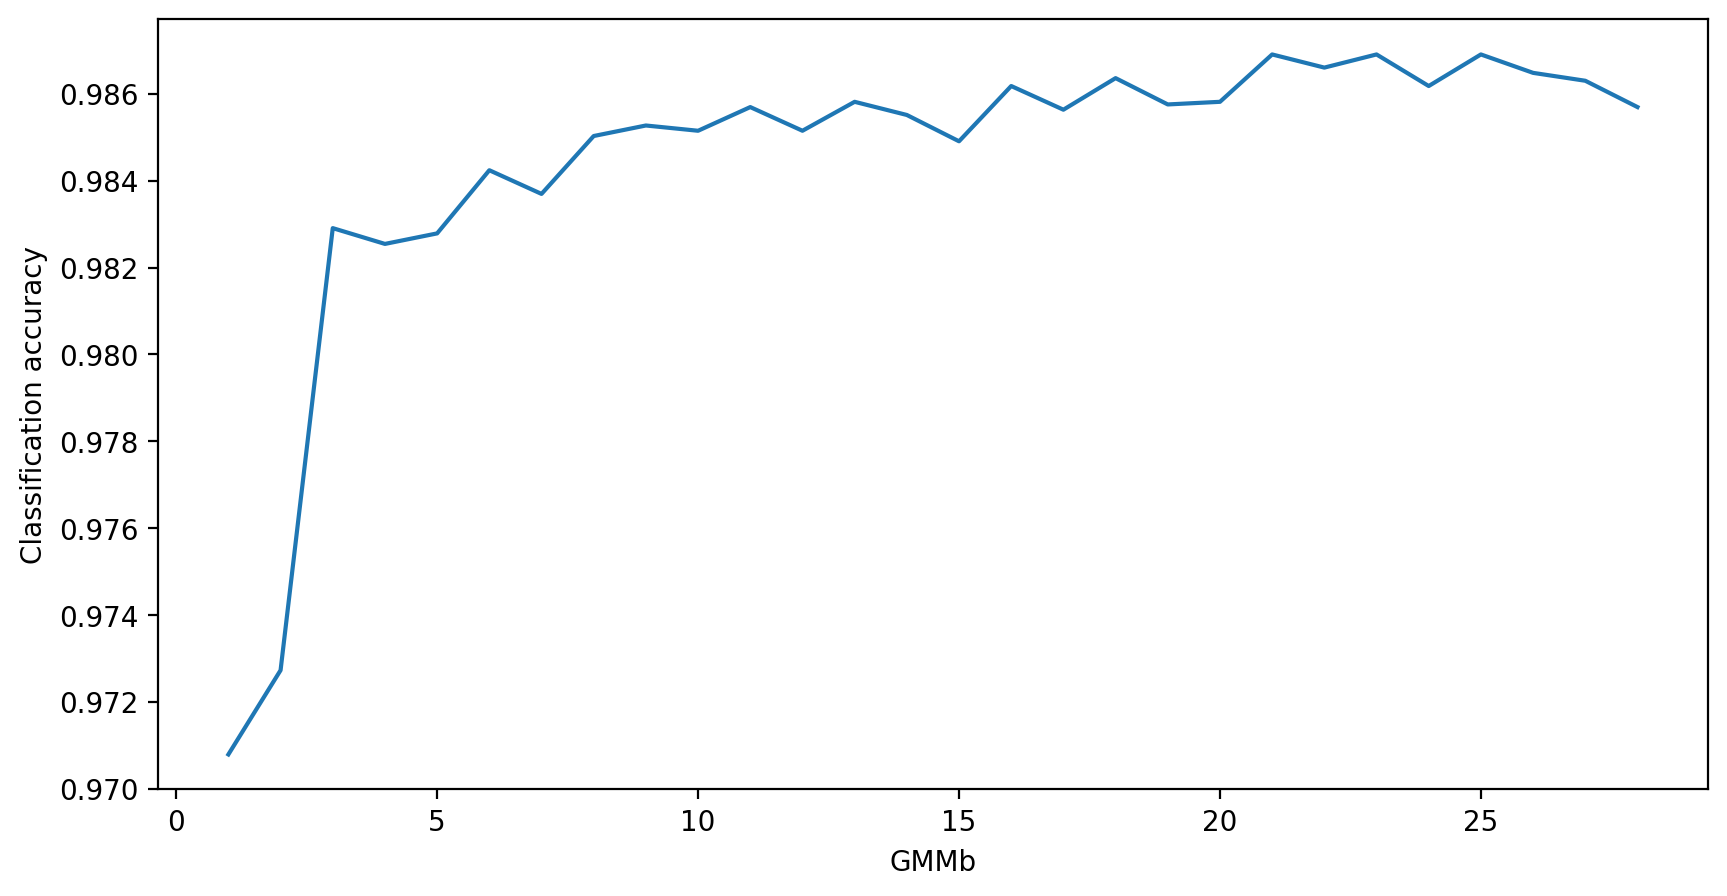

In [233]:
fig = plt.figure(figsize=(10, 5))
u = np.arange(len(classification_acc_all))+1
plt.plot(u,classification_acc_all)
plt.xlabel('GMMb')
plt.ylabel('Classification accuracy');

In [237]:
gmmb_all = GMMBayes(ks[np.argmax(classification_acc_all)])
gmmb_all.fit(X_train_all, y_train_all)
y_pred_GMM_all = gmmb_all.predict(X_test_all)

In [238]:
completenessGMM_all, contaminationGMM_all = completeness_contamination(y_pred_GMM_all, y_test_all)

print(f'Completeness:  {completenessGMM_all:.3f}')
print(f'Contamination: {contaminationGMM_all:.3f}')

Completeness:  0.947
Contamination: 0.046


##### Roc Curve

In [242]:
y_score_GMM_all = [gmmb_all.predict_proba(X_test_all)[:,0], gmmb_all.predict_proba(X_test_all)[:,1]]

Text(0.5, 1.0, 'ROC Curve')

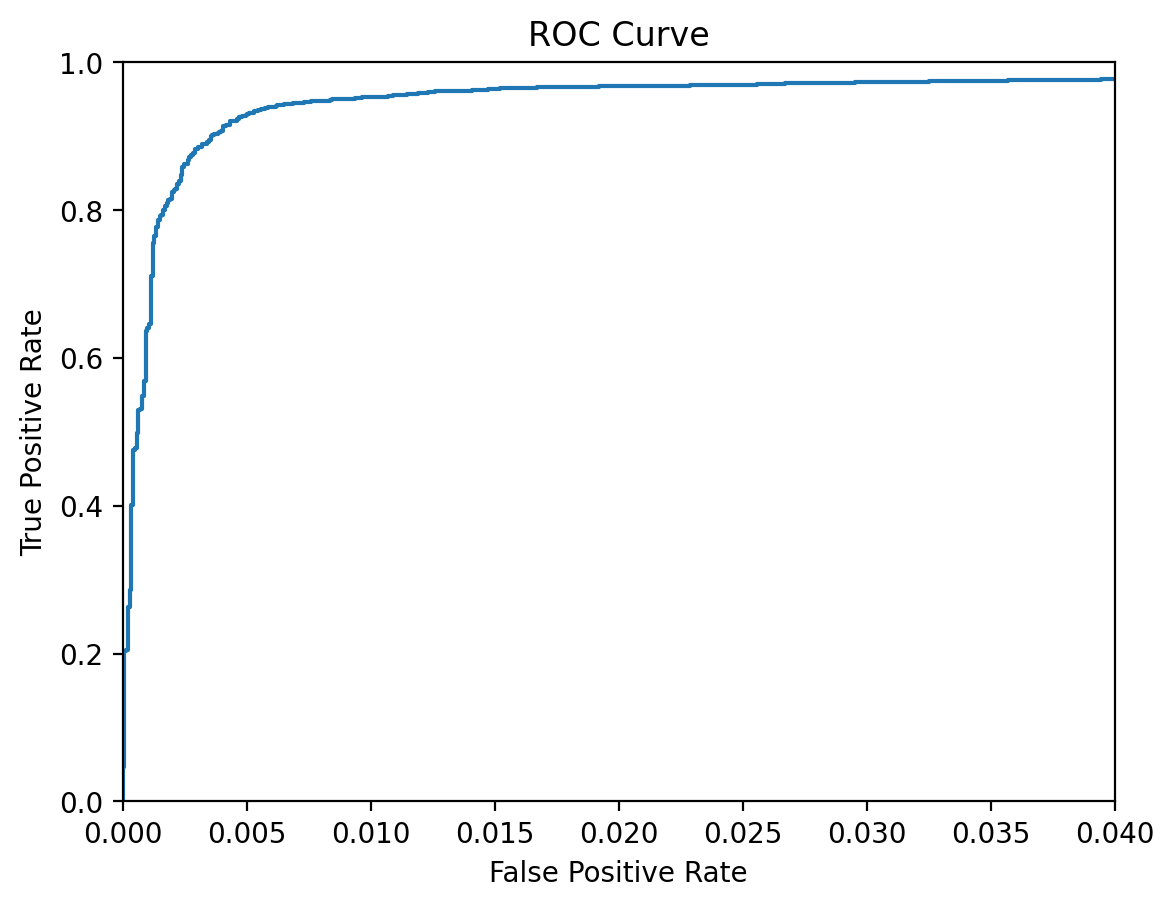

In [243]:
fpr, tpr, _ = roc_curve(y_test_all, y_score_GMM_all[1], pos_label=None, sample_weight=None, drop_intermediate=True)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlim(0, 0.04)
plt.ylim(0,1)
plt.title('ROC Curve')

### K-Nearest Neighbors (KNN)

In [244]:
import warnings
warnings.filterwarnings('ignore')   # Avoid Warnings

#### u-g

In [248]:
# How many neighbors? --> CV
classification_acc = []
ks = np.arange(1,30)

for k in ks:
    knn = KNeighborsClassifier(k)
    CV_pred_k = cross_val_predict(knn, X_test[:,None], y_test)
    classification_acc.append(accuracy_score(y_test, CV_pred_k))

In [249]:
print(f'Max Accuracy for k = {ks[np.argmax(classification_acc)]}')

Max Accuracy for k = 29


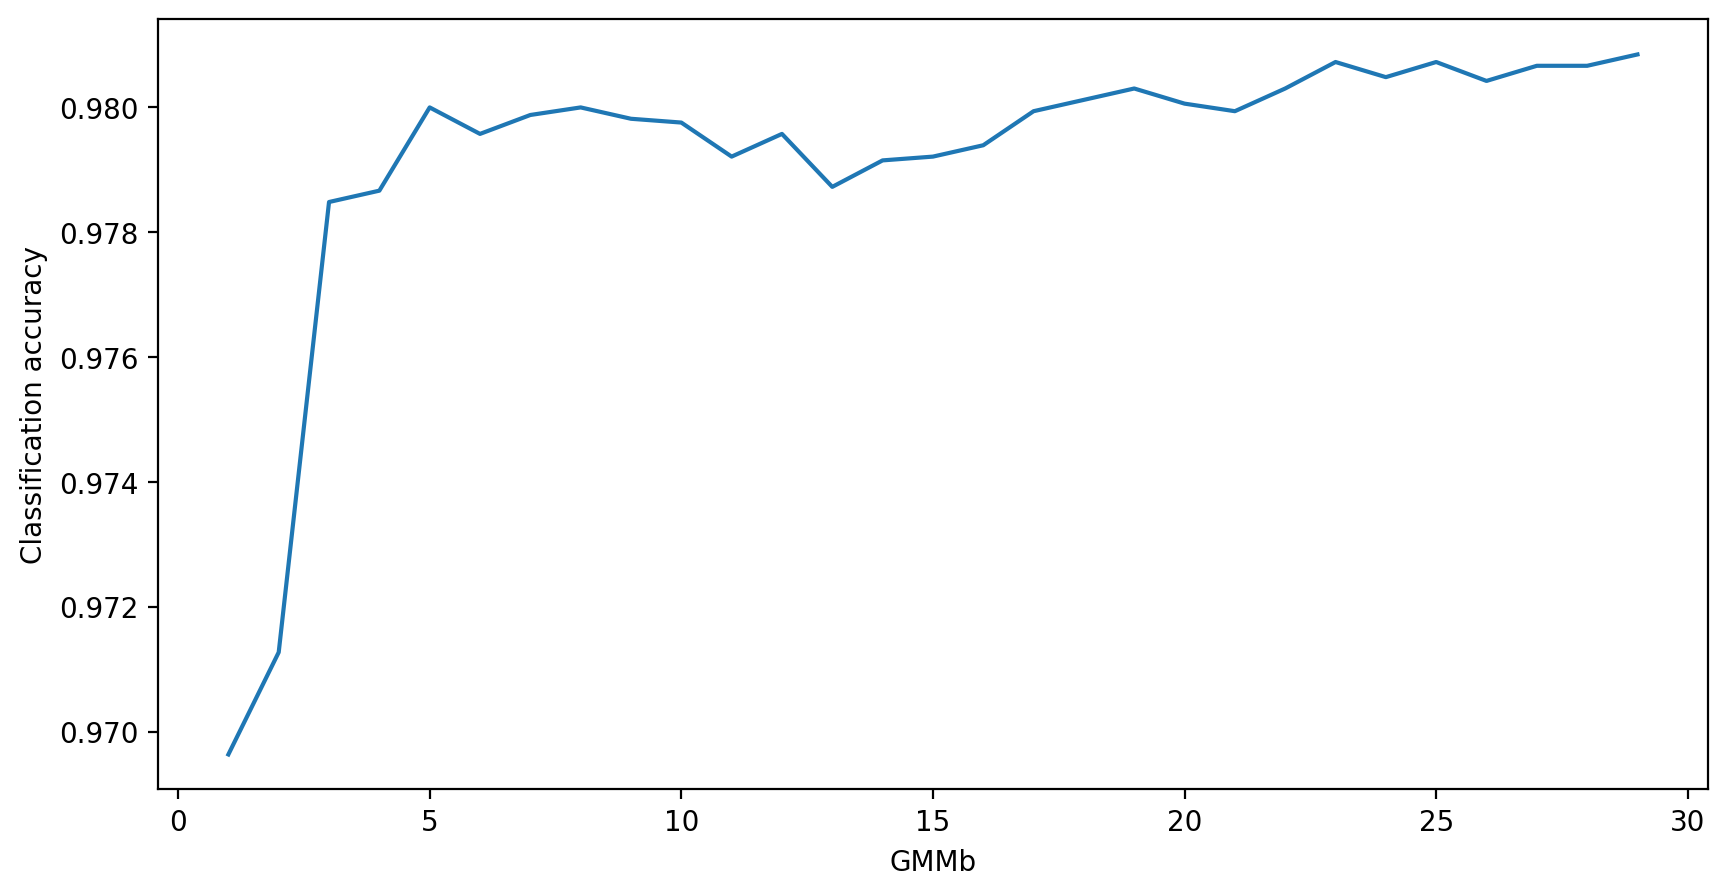

In [250]:
fig = plt.figure(figsize=(10, 5))
u = np.arange(len(classification_acc))+1
plt.plot(u,classification_acc)
plt.xlabel('GMMb')
plt.ylabel('Classification accuracy');

In [252]:
knc = KNeighborsClassifier(ks[np.argmax(classification_acc)])
knc.fit(X_train[:,None], y_train)

y_pred_KNC = knc.predict(X_test[:,None])

completenessKNC, contaminationKNC = completeness_contamination(y_pred_KNC, y_test)

print(f'Completeness:  {completenessKNC:.3f}')
print(f'Contamination: {contaminationKNC:.3f}')

Completeness:  0.940
Contamination: 0.072


##### ROC Curve

In [253]:
y_score_KNC = [knc.predict_proba(X_test[:,None])[:,0], knc.predict_proba(X_test[:,None])[:,1]]

Text(0.5, 1.0, 'ROC Curve')

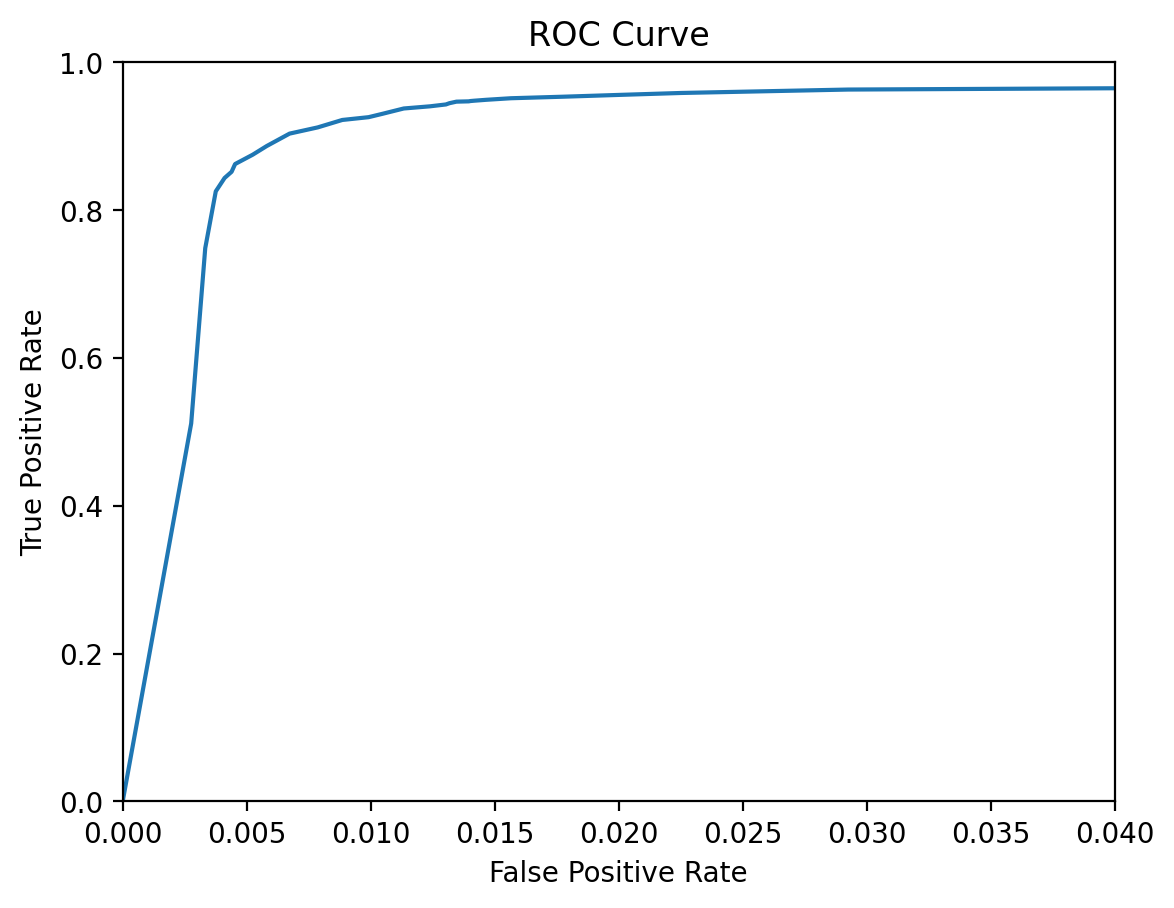

In [254]:
fpr, tpr, _ = roc_curve(y_test, y_score_KNC[1], pos_label=None, sample_weight=None, drop_intermediate=True)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlim(0, 0.04)
plt.ylim(0,1)
plt.title('ROC Curve')

#### Full Dataset

In [258]:
# How many neighbors? --> CV
classification_acc_all = []
ks = np.arange(1,30)

for k in ks:
    knn = KNeighborsClassifier(k)
    CV_pred_k = cross_val_predict(knn, X_test_all, y_test_all)
    classification_acc_all.append(accuracy_score(y_test_all, CV_pred_k))

In [259]:
print(f'Max Accuracy for k = {ks[np.argmax(classification_acc_all)]}')

Max Accuracy for k = 7


In [261]:
knc_all = KNeighborsClassifier(ks[np.argmax(classification_acc_all)])
knc_all.fit(X_train_all, y_train)

y_pred_KNC_all = knc_all.predict(X_test_all)

completenessKNC_all, contaminationKNC_all = completeness_contamination(y_pred_KNC_all, y_test_all)

print(f'Completeness:  {completenessKNC_all:.3f}')
print(f'Contamination: {contaminationKNC_all:.3f}')

Completeness:  0.950
Contamination: 0.044


##### ROC Curve

In [262]:
y_score_KNC_all = [knc_all.predict_proba(X_test_all)[:,0], knc_all.predict_proba(X_test_all)[:,1]]

Text(0.5, 1.0, 'ROC Curve')

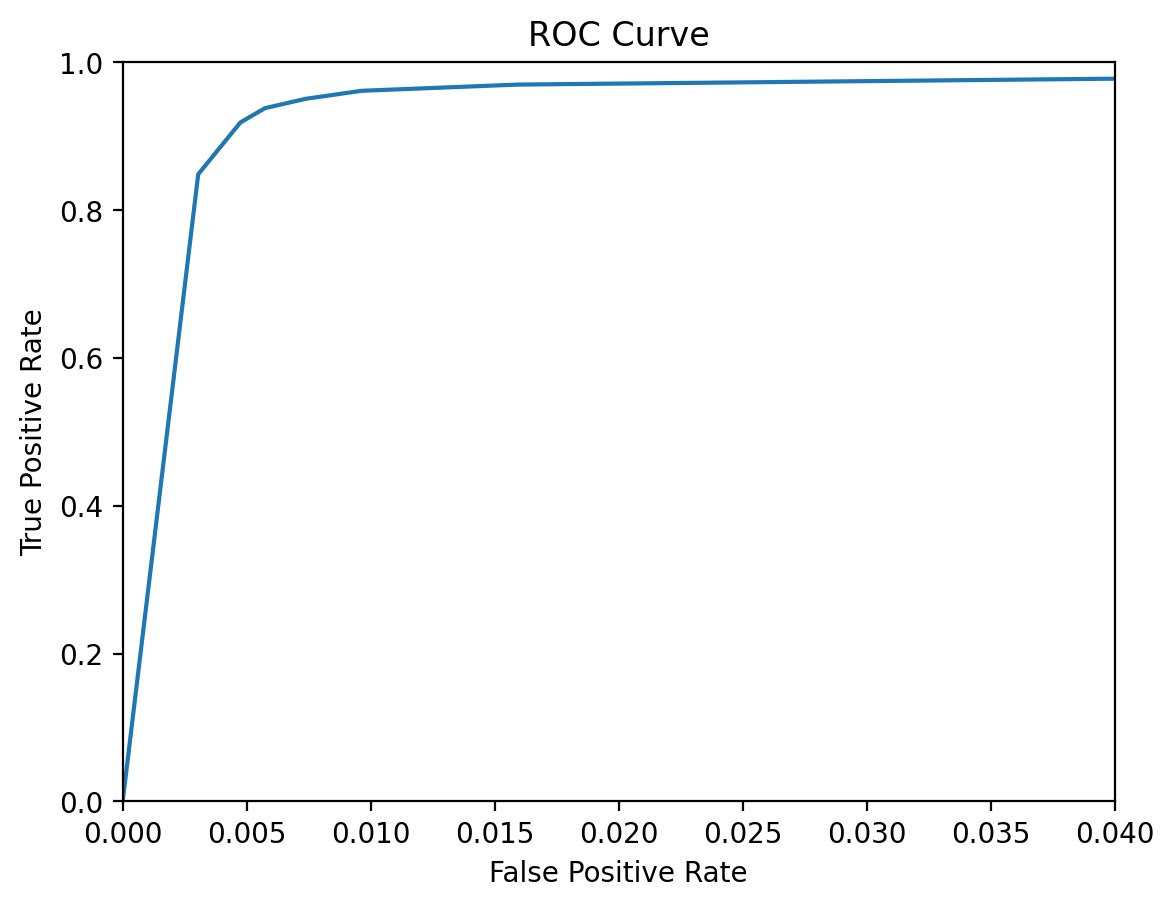

In [265]:
fpr, tpr, _ = roc_curve(y_test_all, y_score_KNC_all[1], pos_label=None, sample_weight=None, drop_intermediate=True)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.xlim(0, 0.04)
plt.ylim(0,1)
plt.title('ROC Curve')

## ROC Curves Comparison

In [273]:
# Fit all the models to the training data
def compute_models(*args):
    names = []
    probs = []
    
    print('classifiers: ')
    print(' ')
    
    for classifier, kwargs in args:
        print(classifier.__name__)
        clf = classifier(**kwargs)
        clf.fit(X_train[:, None], y_train)
        
        #Note that we are outputing the probabilities [of class 1], not the classes
        y_probs = clf.predict_proba(X_validation[:, None])[:, 1]

        names.append(classifier.__name__)
        probs.append(y_probs)

    return names, probs

In [274]:
names, probs = compute_models((GaussianNB, {}),
                              (LDA, {}),
                              (QDA, {}),
                              (KNeighborsClassifier,
                               dict(n_neighbors=29)),
                              (GMMBayes, dict(n_components=2)))

classifiers: 
 
GaussianNB
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
KNeighborsClassifier
GMMBayes


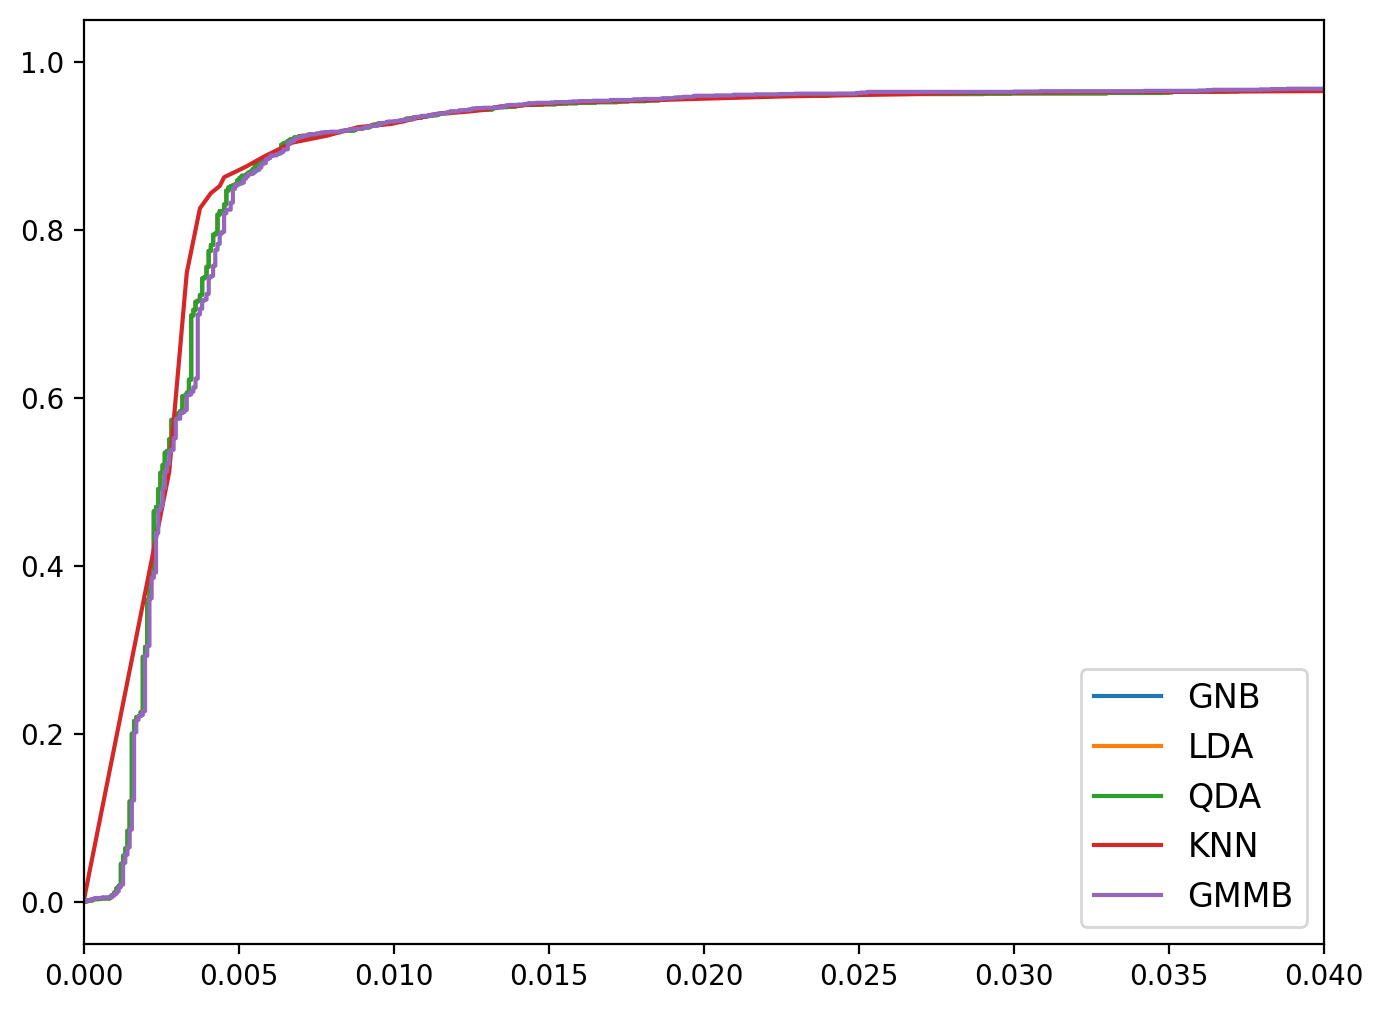

In [283]:
labels = dict(GaussianNB='GNB',
              LinearDiscriminantAnalysis='LDA',
              QuadraticDiscriminantAnalysis='QDA',
              KNeighborsClassifier='KNN',
              DecisionTreeClassifier='DT',
              GMMBayes='GMMB',
              LogisticRegression='LR')

plt.figure(figsize=(8, 6))

for name, y_prob in zip(names, probs):
    
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    precision, recall, thresh2 = precision_recall_curve(y_test, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    
    # Here we add (1,0) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])
    
    plt.plot(fpr, tpr, label=labels[name])
    
    plt.xlim(0, 0.04)
    
    plt.legend(loc='lower right', fontsize=12)

In [284]:
# Fit all the models to the training data
def compute_models_NDIM(*args):
    names = []
    probs = []
    
    print('classifiers: ')
    print(' ')
    
    for classifier, kwargs in args:
        print(classifier.__name__)
        clf = classifier(**kwargs)
        clf.fit(X_train_all, y_train_all)
        
        #Note that we are outputing the probabilities [of class 1], not the classes!
        y_probs = clf.predict_proba(X_validation_all)[:, 1]

        names.append(classifier.__name__)
        probs.append(y_probs)

    return names, probs


In [285]:
names_NDIM, probs_NDIM = compute_models_NDIM((GaussianNB, {}),
                              (LDA, {}),
                              (QDA, {}),
                              (KNeighborsClassifier,
                               dict(n_neighbors=7)),
                              (GMMBayes, dict(n_components=22)))

classifiers: 
 
GaussianNB
LinearDiscriminantAnalysis
QuadraticDiscriminantAnalysis
KNeighborsClassifier
GMMBayes


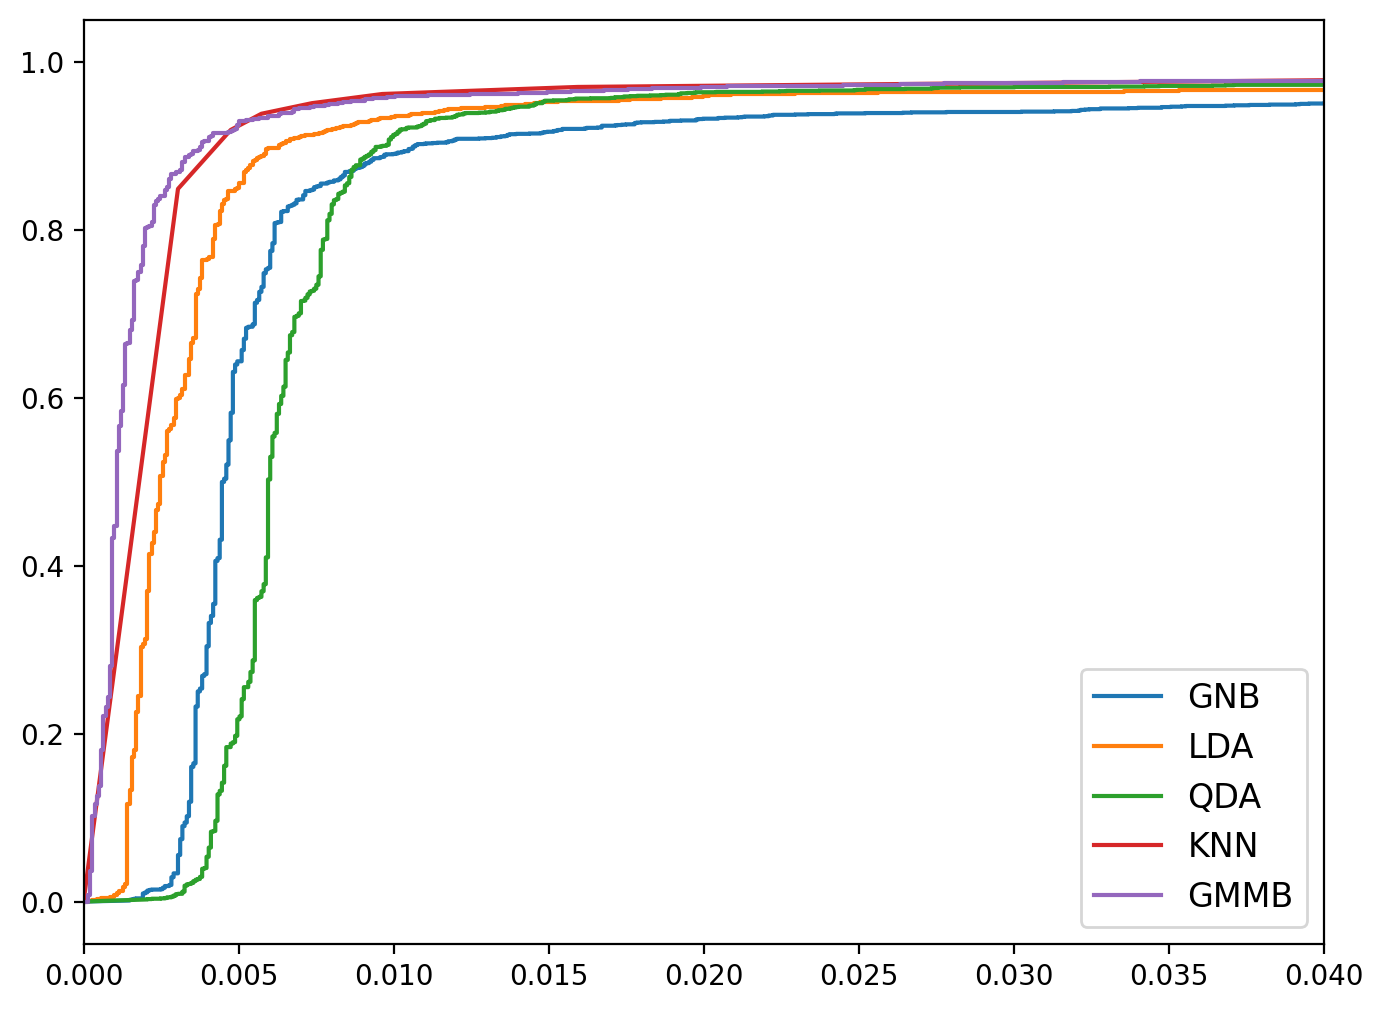

In [286]:
plt.figure(figsize=(8, 6))

for name, y_prob in zip(names_NDIM, probs_NDIM):
    
    fpr, tpr, thresh = roc_curve(y_test_all, y_prob)
    precision, recall, thresh2 = precision_recall_curve(y_test_all, y_prob)

    # add (0, 0) as first point
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    
    # Here we add (1,0) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])
    
    plt.plot(fpr, tpr, label=labels[name])
    
    plt.xlim(0, 0.04)
    
    plt.legend(loc='lower right', fontsize=12)

## Different Colors (Using GMM)

In [288]:
data['u'].shape, data['g'].shape, data['r'].shape, data['i'].shape, data['z'].shape

((50000,), (50000,), (50000,), (50000,), (50000,))